

> Importación de librerías usadas para el proyecto



In [3]:
import codecs                               #libreria que sirve para leer el svg como un string 
import cairosvg                             #sirve para convertir el texto svg en formato de bytes 
import matplotlib.pyplot as plt             #graficas (Versión 1.5.3)
import pandas as pd                         #manejo de datos
import numpy as np                          #manipulacion de arreglos y operaciones matematicas complejas
import matplotlib.animation as animation    #animacion de graficas 
#from numba import njit                     #posible utilizacion en calculos que requiren computo matematico (no sirve para df)
from io import BytesIO                      #manipualdor de bytes, funciona en conjunto con cairosvg
from PIL import Image                       #conversion de bytes en imagen reconocible por numpy 
from scipy.signal import butter, lfilter, freqz


> Conversión de bits de PNG a formato Numpy (matrices) facilita la visualizacion y manipulacion



In [4]:
def png_bytes_to_numpy(png):
    """Convert png bytes to numpy array

    Example:  

    >>> fig = go.Figure(go.Scatter(x=[1], y=[1]))
    >>> plt.imshow(png_bytes_to_numpy(fig.to_image('png')))
    """
    return np.array(Image.open(BytesIO(png)))



> Función que se encarga de formatear la información cruda de la hoja seleccionada del DF para obtener solamente los datos de alineación de los sensores



In [5]:
def get_form_data(Diccionary,sheet):
    alineacion = Diccionary.get(sheet)
    alingREad = alineacion.iloc[8:,:199] #Para llamar las lecturas de los sensores.
    EncabezadoAling = alingREad.iloc[0]
    alingREad.columns = EncabezadoAling
    alingREad=alingREad.drop(labels=[8], axis=0)
    return alingREad



> Definición de función que inicializa los datos que se utilizaran en el script



In [6]:
def init_fnc(filename):
    global content_svg                                                          #variable global que contiene los svg
    content_svg=[]
    for _file in filename:                                                      #dependiendo de los archivos svg que le pasemos como parametro
        with codecs.open(_file, encoding='utf-8', errors='ignore') as f:        #loslee y codifica segun utf-8
            svg_as_text=f.read()
            svg_as_text=svg_as_text.replace('"st0"', '"stk"')                   #reemplazamos "st0" con "stk" para no ir a modificar erroneamente los estilos
            for i in range(99):                                                 #esto se hace para que cada objeto dentro del svg tenga un identificador de 
                svg_as_text=svg_as_text.replace('"stk"','"st{}"'.format(i),1)   #la funcion format es nativa de python y sirve para modificar strings
            content_svg.append(svg_as_text)                                     #clase propio con el fin de poder modificar su color a traves de estos identificadores



> Función para convertir datos SVG a Imagen



In [7]:
def svg2img(foot,data_sensors):
    global content_svg
    
    content=content_svg[foot]                                                               #dependiendo del svg escogido, escribimos la variable conten
    style_m1=".st{0}{1}\n\t"                                                                #esta es la definicion del estilo css mediante un string
    style_m2="{{fill:#{0}}}"                                                                #para que quede ".st{0}{fill:#{1};}" donde cero y 1 corresponden 
    style_temp=""                                                                           #a los valores que se van a modificar al igual que los corchetes {}
                                                                                            #de modo que ejemplo para la clase st2 y color 000F00 quedaria: 
    for i in range(len(data_sensors)):                                                      #.st2{fill:#000F00;}
        k=''                                                                                #en este for se itera por cada valor del dataframe pasado [1:100]
        k=['0' for i in range(6-len(data_sensors[i]))]                                      #para ajustar el el formato se agregan los 0 necesarios en este for
        k="".join(k)
        if len(data_sensors[i])>0:
            style_temp+=style_m1.format(i,style_m2.format(k+str(data_sensors[i])+';'))
        else:
            style_temp+=style_m1.format(i,style_m2.format('000000;'))                       #por ultimo se concatenan todas las clases, ejemplo:
                                                                                            #.st2{fill:#000F00;}
                                                                                            #.st3{fill:#000F00;}...
    style_c=content.find('.st0')                                                            #se busca este valor en el svg original que corresponde a la unica clase definida
    sub_str=content[style_c:style_c+19]                                                     #y se modifica para todas las clases necesarias para modificar los diferentes colores
    svg_loc=content.replace(sub_str, style_temp)

    png_data = cairosvg.svg2png(bytestring=svg_loc.encode())                               #ahora se convierte el texto svg en datos de imagen bytes
    img_out=png_bytes_to_numpy(png_data)                                                   #y lo pasamos por la funcion para que nos retorne en forma de matriz
    return img_out

> Función que permite graficar de acuerdo al dataframe pasado como parámetro

In [8]:
def render_animation(data_frame):
    #inicializacion de variables
    ims = [] 
    max_dts=data_frame.max(skipna=True)#determina el la columna con el valor maximo y devuelve sus valores
    max_dt=max(max_dts)#determinacion del maximo valor del dataframe para normalizarlo 
    
    for i in range(len(data_frame)-1):
        heat_map = data_frame.iloc[i].to_numpy(copy=True)#seleccion de columna
        heat_map=list(map(float, heat_map))#conversion a flotante
        heat_map=[(y/max_dt)*0x00FFFF for y in heat_map]#normalizacion
        heat_map_v=list(map(int, heat_map))
    
        data_hex=[hex(data)for data in heat_map_v]
        data_str=[data_sh.replace('0x','') for data_sh in data_hex]
        Img_L=svg2img(0,data_str[0:99])#0 para izquierda
        Img_R=svg2img(1,data_str[99:198])#1 para derecha
    
        im_l= ax1.imshow(Img_L, animated=True)
        im_r= ax2.imshow(Img_R, animated=True)
        if i == 0:
            ax1.imshow(Img_L)  # show an initial one first
            ax2.imshow(Img_R)
        ims.append([im_l,im_r])
    return ims

> Funciones para el proceso de filtrado

In [17]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_lowpass_df(data_frame):#creada por el usuario para simplificar los datos y graficarlos
    order = 3
    fs = 50.0       
    cutoff = 3.667
    
    df_filtred=[]
    for yval in range(0,198):
      ydata=data_frame.iloc[0:,yval].to_numpy(copy=True)
      ydata_float=list(map(float,ydata))
      y_fill = butter_lowpass_filter(ydata_float, cutoff, fs, order)
      y_int=list(map(int,y_fill))
      df_filtred.append(y_int)
      
    df = pd.DataFrame(df_filtred)
    df_sens=df = df.transpose( )
    return df_sens



> Cargue del Excel y guardado en Diccionario de datos. Precarga de archivos SVG



In [10]:
Archivo = 'PRESION_NO_ALIN_V2.xlsx' #Carga el excel
Diccionario = pd.read_excel(Archivo, sheet_name=None, index_col=False)

#Sujetos = Diccionario.get('SUJETOS')

init_fnc(["foot L.svg","foot R.svg"]) #Precarga los svg del directorio para L y R



> Visualización 2D



C:\Users\jabril\AppData\Local\Temp\ipykernel_27376\4143158856.py:4: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  max_dts=data_frame.max(skipna=True)#determina el la columna con el valor maximo y devuelve sus valores


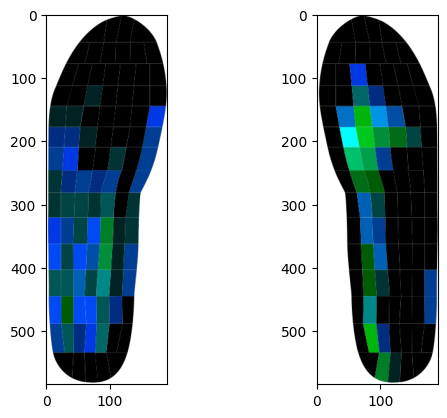

In [15]:
data_readed= get_form_data(Diccionario,'ALIN1') #llamado de funcion que retorna el dataframe 

fig, (ax1, ax2) = plt.subplots(1,2)
ims=render_animation(data_readed) #llamado a funcion para animar
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.show() #Funciona

> Filtrado

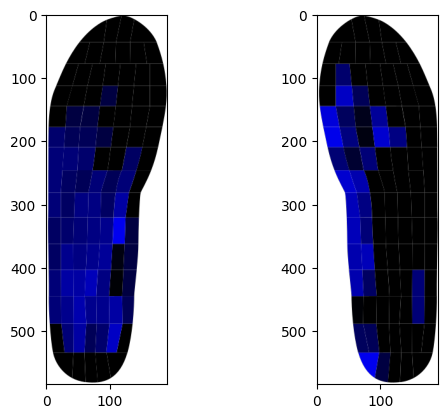

In [18]:
df_sens=filter_lowpass_df(data_readed.iloc[0:,1:])
fig, (ax1, ax2) = plt.subplots(1,2)
ims=render_animation(df_sens)#llamado a funcion para animar
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.show() #Funciona

In [13]:
data_readed.iloc[0:,1:].max()

C:\Users\jabril\AppData\Local\Temp\ipykernel_27376\1769769292.py:1: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_readed.iloc[0:,1:].max()


8
3.0     15000.0
4.0         0.0
5.0         0.0
6.0     15000.0
7.0     47500.0
         ...   
95.0        0.0
96.0        0.0
97.0        0.0
98.0        0.0
99.0        0.0
Length: 196, dtype: float64

In [19]:
m_d=df_sens.iloc[0:,1:].to_numpy(copy=True)

In [20]:
m_d[0]

array([  0,   0,   0,   0,   0, 364, 202, 162, 304, 222,   0, 162, 304,
       263, 263, 324, 263, 222, 121, 486, 243, 344, 304, 304, 222, 121,
       506, 283, 263, 243, 263, 182, 121, 445, 263, 243, 222, 202, 182,
         0, 304, 182, 243, 243, 182, 222,   0, 222, 162, 222, 162, 182,
       222,   0, 182,   0,   0, 202, 222, 222,   0,   0,   0, 121, 162,
       162, 202,   0,   0,   0,   0, 121, 121,   0,   0,   0,   0, 121,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 445, 121,   0,   0,   0, 648,
       162,   0,   0,   0,   0,   0, 486,   0,   0,   0,   0, 222,   0,
       324, 182,   0,   0,   0, 222,   0, 324, 344,   0,   0,   0,   0,
         0, 344, 222,   0,   0,   0,   0,   0, 344, 243,   0,   0,   0,
         0,   0, 385, 324,   0,   0,   0,   0,   0, 689, 567, 222,   0,
         0,   0,   0, 912, 709, 506, 385, 243,   0,   0, 405, 648, 526,
       283,   0,   0,   0,   0, 364, 162,   0,   0,   0,   0,   

In [21]:
maxim_data= [max(list(map(float,m))) for m in m_d]
max(maxim_data)

121588.0